In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cPickle as pickle

import time

# python packages
import sys
import os
import glob
from socket import gethostname
#from collections import defaultdict

import numpy as np
import numpy.lib.recfunctions

# scipy-project imports
import scipy.interpolate
import scipy.optimize
import scipy.stats
from scipy.special import erf, erfinv, erfc

# Misc
from ic_data import load_data, prepare_directory
import ic_utils as utils

# Plotting
import seaborn as sns
from matplotlib.colors import LogNorm

import matplotlib as mpl
plt = utils.plotting("pdf")

from collections import defaultdict
from scipy.interpolate import UnivariateSpline
from skylab.prior_generator import UhecrPriorGenerator

print ":)"

:)


In [308]:
print(gethostname())
basepath, inipath, savepath, crpath, figurepath = utils.get_paths(gethostname())
print savepath
print figurepath

cobalt03.icecube.wisc.edu
/data/user/lschumacher/projects/stacking/hotspot_fitting
/home/lschumacher/public_html/uhecr_stacking/hotspot_fit


## Read UHECR data

In [4]:
n_cr = dict()
pg = UhecrPriorGenerator(6)
for e in np.arange(50, 160, 5):
    pg._get_UHECR_positions(e, crpath)
    n_cr[e] = pg.n_uhecr

## Read Background trials

In [5]:
name = sorted(glob.glob(os.path.join(savepath,"*_bg_TS_ts-fix.pickle")))
print name

['/data/user/lschumacher/projects/stacking/hotspot_fitting/1522746526_bg_TS_ts-fix.pickle', '/data/user/lschumacher/projects/stacking/hotspot_fitting/1522828396_bg_TS_ts-fix.pickle', '/data/user/lschumacher/projects/stacking/hotspot_fitting/1523625437_bg_TS_ts-fix.pickle']


In [6]:
with open(name[-1], "rb") as f:
    bg_TS = pickle.load(f)

## Read Signal trials

In [66]:
names = sorted(glob.glob(os.path.join(savepath, "*_signal_TS_fit-gamma_pole-cut.pickle")))
#print names

with open(names[-1], "rb") as f:
    signals = pickle.load(f)

In [19]:
names = sorted(glob.glob(os.path.join(savepath, "*_final-n.pickle")))
print names

with open(names[-1], "rb") as f:
    final_n = pickle.load(f)

['/data/user/lschumacher/projects/stacking/hotspot_fitting/1523625437_final-n.pickle']


## Raw flux for ${n}_{inj}$ -> flux calculation

In [12]:
## Flux calculations

sinDec = np.loadtxt(os.path.join(crpath, "sindec_bins_gamma-2.19.npy"))

raw_fluxes = np.loadtxt(os.path.join(crpath, "raw_fluxes_gamma-2.19.npy"))
sum_flux = raw_fluxes.sum(axis=0)

sinDec_x = np.linspace(min(sinDec), max(sinDec), num=100)
flux_spline = scipy.interpolate.InterpolatedUnivariateSpline(
                                (sinDec[1:] + sinDec[:-1]) / 2.,
                                sum_flux/(2*np.pi*(sinDec[1:] - sinDec[:-1])), k=2)

"""flux_spline
plt.figure()
plt.plot(sinDec_x, flux_spline(sinDec_x))
plt.ylabel(r"Raw flux $E^{-2.19}$")
plt.show()
#"""

raw_fluxes = np.loadtxt("/home/lschumacher/git_repos/general_code_repo/data/raw_fluxes_gamma-2.19.npy")
print raw_fluxes.sum()*1.01*np.power(10,-18.+3+2*2.19)/np.sqrt(7./8.)

360.9037438975409


## Calculating inj-fit distances

In [ ]:
from ic_utils import angular_distance, angular_dist

In [15]:
import pandas as pd

In [275]:
distance_cut = 0.5
bins = 80
range = (0,40)
fcounter = 0
new=True
for md in signals:
    ecuts = np.sort(signals[md].keys())
    for ecut in ecuts:
        mu = np.sort(signals[md][ecut].keys())
        for i,ak in enumerate(mu):
            
            nsig = np.array(signals[md][ecut][ak])
            ind_sources = []
            for nd,nr in zip(nsig['dec'], nsig['ra']):
                nd = np.array(nd, dtype=np.complex64)
                nd.imag = nr
                ind_sources.append(len(np.unique(np.round(nd, decimals=2))))
            ind_sources = np.array(ind_sources)
            # Calculate distance from one hotspot to the matching injected source
            distance = np.degrees(angular_distance([nsig['dec'], nsig['ra']],
                                                   [nsig['dec_inj'], nsig['ra_inj']])).flatten()
            
            # Count as "correct" if distance is smaller than distance_cut (e.g. 0.5deg)
            # This way we see which injected sources have actually been found
            # Normalize to total number of hotspots
            n1 = np.count_nonzero(distance<=distance_cut)*1./len(distance)
            
            # Calculate distance from all hotspots to all other injected sources
            # Then, find the minimum distance for each
            # This way, we see also hotspots that have been fitted multiple times
            if nsig['dec'].ndim>1:
                distance = np.degrees(angular_dist(nsig['dec'], 
                                                   nsig['ra'],
                                                   nsig['dec_inj'], 
                                                   nsig['ra_inj']))
                distance = np.min(distance, axis=-1).flatten()
            n2 = np.count_nonzero(distance<=distance_cut)*1./len(distance)
            
            if new:
                frame = pd.DataFrame({
                    "md": md, 
                    "ecut": ecut, 
                    "nsources": ind_sources, 
                    "ncr": n_cr[ecut], 
                    "ninj": nsig["n_inj"].sum(axis=-1),
                    "mu": ak,
                    "dir_match": n1,
                    "ov_match": n2,
                    "ratio_match": (n2-n1)*1./n1,
                })
                new = False
            else:
                frame = frame.append(pd.DataFrame({
                    "md": md, 
                    "ecut": ecut, 
                    "nsources": ind_sources, 
                    "ncr": n_cr[ecut], 
                    "ninj": nsig["n_inj"].sum(axis=-1),
                    "mu": ak,
                    "dir_match": n1,
                    "ov_match": n2,
                    "ratio_match": (n2-n1)*1./n1,
                }), ignore_index=True)

print "done" 
frame["ncr-nsources"] = frame.ncr-frame.nsources

done


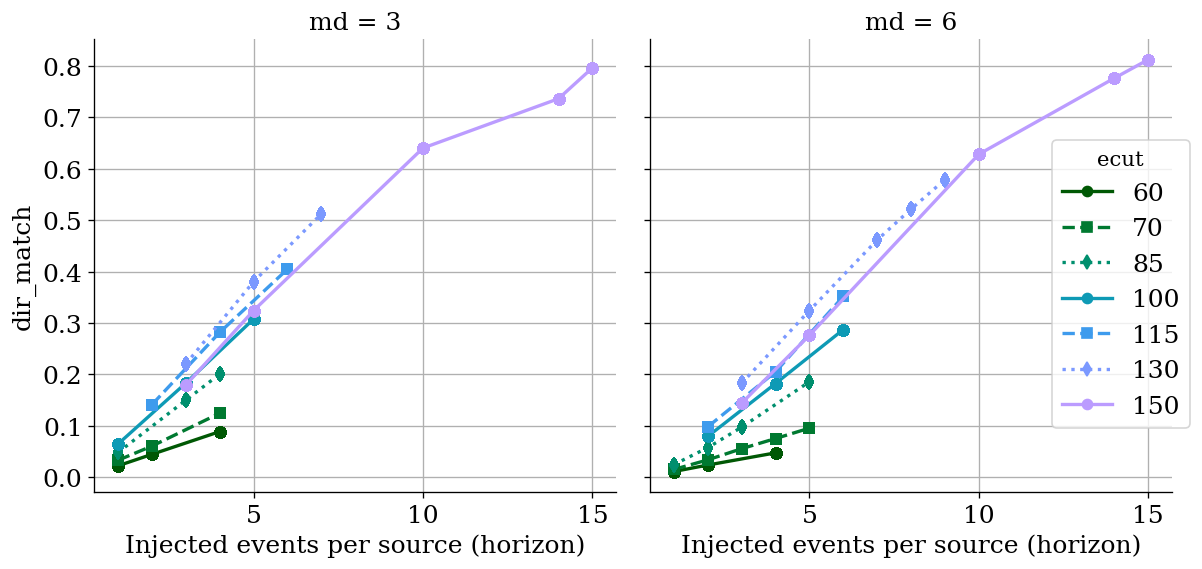

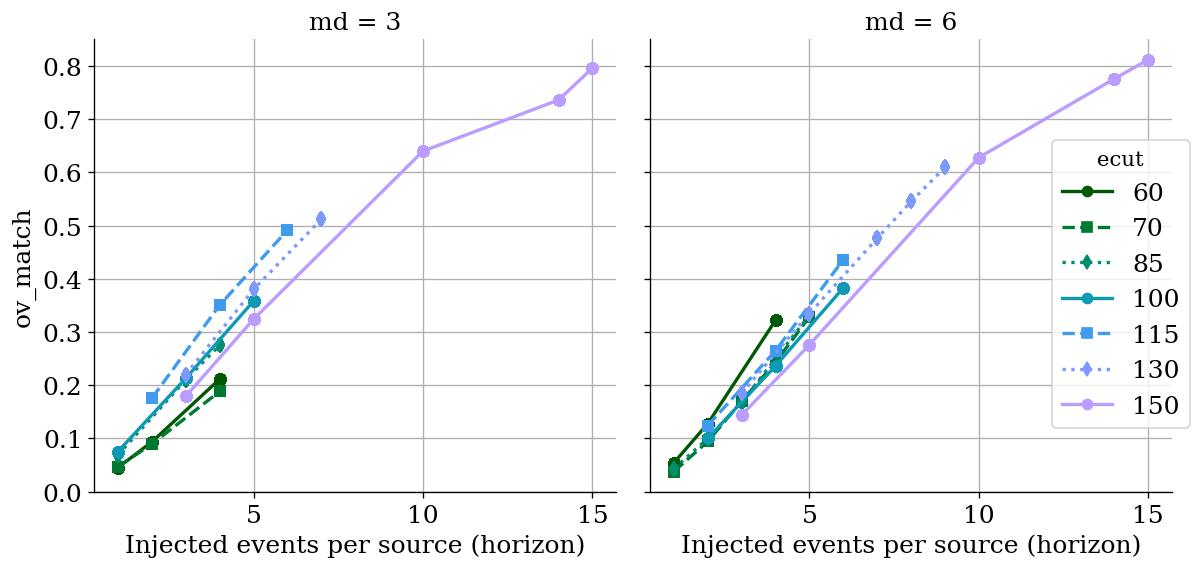

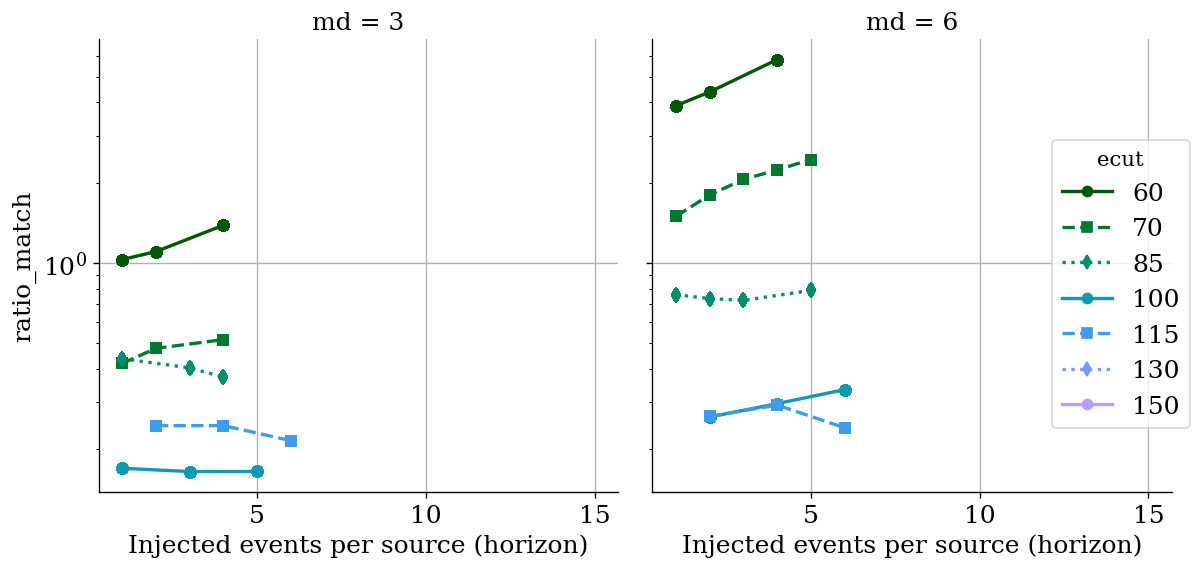

In [309]:
ncolor = len(signals[3].keys())
colors = sns.cubehelix_palette(ncolor, start=1.5, rot=.75, dark=0.2, light=0.7, reverse=True, hue=2)
size = 5
aspect = 0.9
keys = ["dir_match", "ov_match", "ratio_match"]

for k in keys:
    grid = sns.FacetGrid(frame, col="md", hue="ecut", size=size, aspect=aspect, palette=colors)
    grid = grid.map(plt.plot, "mu", k)
    grid.add_legend(ncol=1)
    grid.set_xlabels("Injected events per source (horizon)")
    if k=="ratio_match": grid.axes[0,0].semilogy()
    grid.savefig(os.path.join(figurepath, "HSP_eval", "HSP_{}.png".format(k)))
plt.show()

## Evaluating how many distinct sources have been found

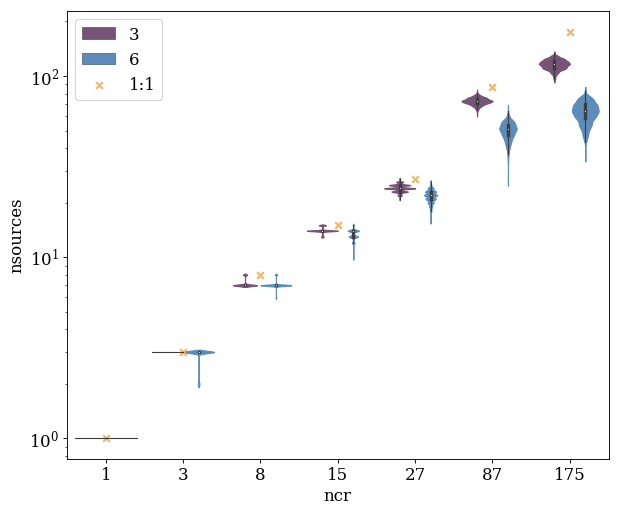

In [592]:
import ic_utils as utils
plt = utils.plain_plotting()

ax = sns.violinplot(x=frame.ncr, y=frame.nsources, hue=frame.md, bw=0.2, inner="box", linewidth=1, palette=utils.light_colors)
x = ax.get_xticks()
y = [int(a.get_text()) for a in ax.get_xticklabels()]
ax.scatter(x, y, color=utils.light_colors[-1], label="1:1", marker="x")
ax.legend(loc=2)
ax.semilogy(nonposy="clip")
ax.figure.savefig(os.path.join(figurepath, "HSP_eval", "HSP_distinct_sources.png"))
#ax.grid(True)
plt.show()


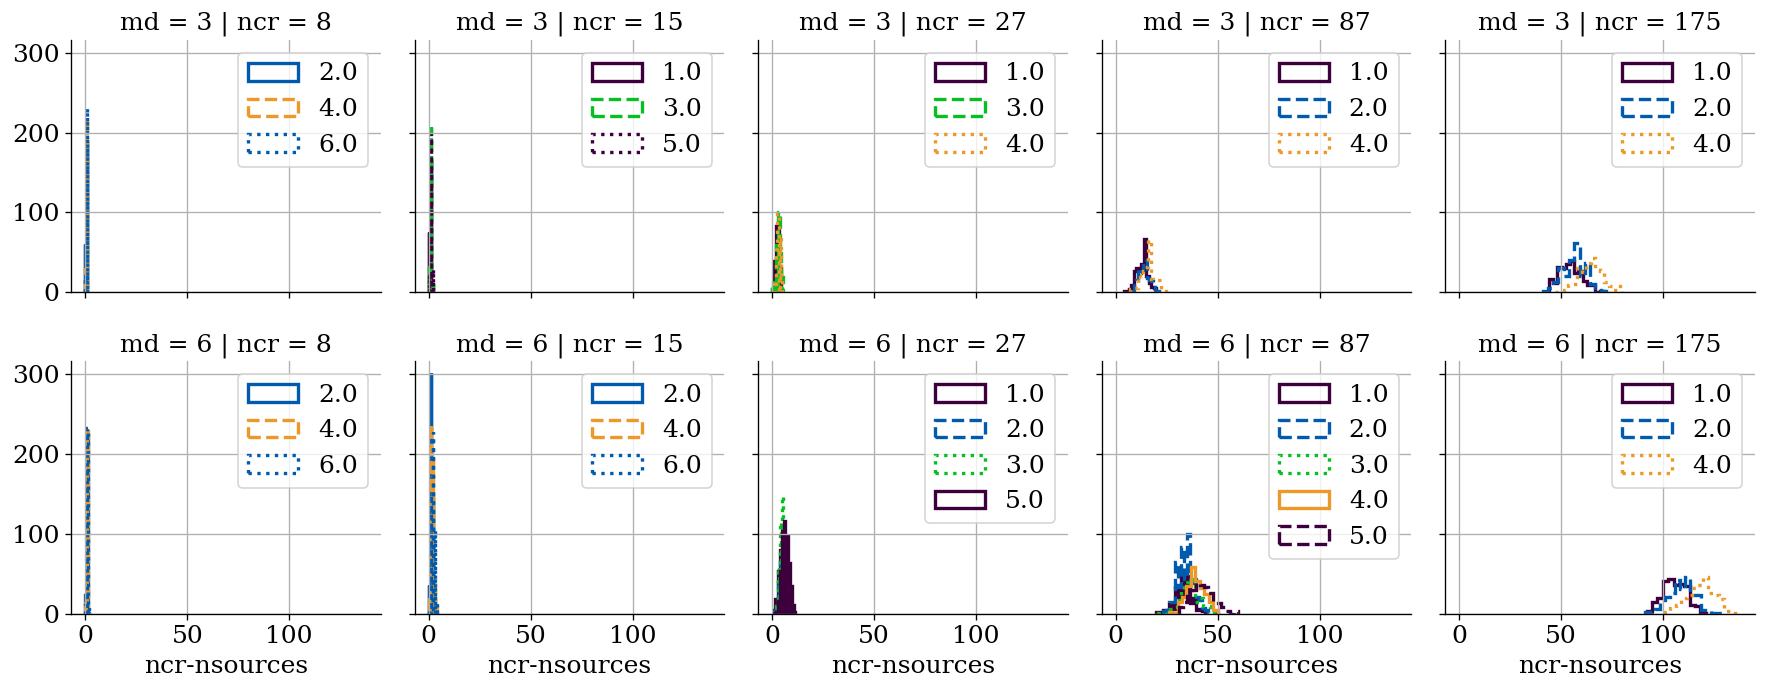

In [593]:
plt = utils.plotting()

grid = sns.FacetGrid(frame[frame.ecut<130], row="md", col="ncr", hue="mu", legend_out=True)
grid = grid.map(sns.distplot, "ncr-nsources", kde=False,
                hist_kws=dict(histtype="step", alpha=1, lw=2, normed=False))
for a in grid.axes.flatten(): a.legend(loc=0)
grid.savefig(os.path.join(figurepath, "HSP_eval", "HSP_distinct_sources_vs_mu.png"))
plt.show()

In [ ]:
bgdict = defaultdict(list)

for md in np.sort(bg_TS.keys()):
    for n in ['ra', 'dec', 'energy']: #bg_TS[md].dtype.names:
        bgdict[n].extend(np.array(bg_TS[md][n]))
    bgdict["md"].extend(np.full_like(bgdict[n], md))

for k in bgdict:
    bgdict[k] = np.array(bgdict[k])

ind_sources = []
mds = []
energycut = []
for ecut in ecuts:
    pos = np.ma.array(bgdict['dec']+bgdict['ra']*1j, dtype=np.complex64, mask=bgdict['energy']<ecut)

    for i,p in enumerate(pos):
        ind_sources.append(len(np.unique(np.round(p, decimals=2))))
        mds.append(bgdict['md'][i][0])
        energycut.append(np.full_like(ind_sources[-1], ecut))
ind_sources = np.array(ind_sources)
mds = np.array(mds)
energycut = np.array(energycut)
bg_frame = pd.DataFrame({
                         "md": mds,
                         "nsources": ind_sources,
                         "ecut": energycut
                        })

bg_frame["ncr"] = bg_frame["ecut"].apply(lambda x: n_cr[x])

bg_frame["mu"] = np.zeros_like(bg_frame.ncr)

In [667]:
bg_frame["ncr-nsources"] = bg_frame.ncr-bg_frame.nsources

In [669]:
combined_frame = pd.concat([bg_frame, frame[bg_frame.columns]])

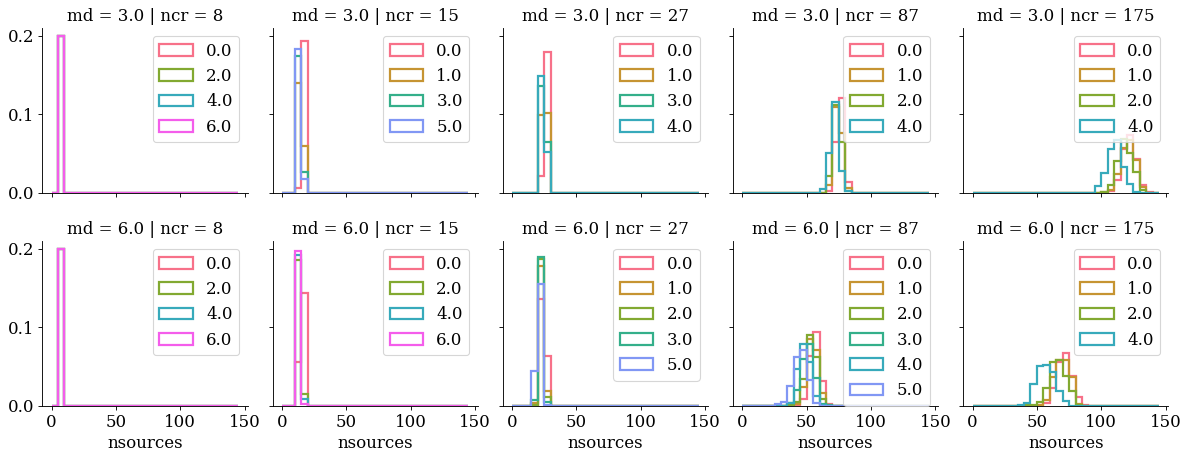

In [676]:
plt = utils.plain_plotting()

grid = sns.FacetGrid(combined_frame[combined_frame.ecut<130], row="md", col="ncr", hue="mu", legend_out=True)
grid = grid.map(sns.distplot, "nsources", kde=False, #kde_kws=dict(markersize=0, bw=1), 
                bins=np.arange(0, 150, step=5), 
                hist_kws=dict(histtype="step", alpha=1, lw=2, normed=True))
for a in grid.axes.flatten(): a.legend(loc=0)
grid.savefig(os.path.join(figurepath, "HSP_eval", "HSP_distinct_sources_vs_mu.png"))
plt.show()

## Evaluate how many sigma hotspots are away from CR center

In [ ]:
bins = 80
cr_nu_dist = dict()
t = UhecrPriorGenerator(6)

markers = ["o", "d", "s", "h"]
saveplots = False
nlim = 10

"""f1, a1 = plt.subplots(1, 2, sharey=True)
a1[0].set_title(r"UHECR neutrino-hotspot distance")"""

for md in mdparams:
    #print "md", md
    cr_nu_dist[md] = dict()
    for ecut in ecuts:
        ra, dec, energy, sigma_reco = t._get_UHECR_positions(ecut,
                                                     data_path=crpath)
        cr_nu_dist[md][ecut]=dict()
        for i,ak in enumerate(signals[md][ecut]):
            
            nsig = np.array(signals[md][ecut][ak])
            print np.shape(nsig['dec']), np.shape(dec)
            # Calculate distance from one hotspot to the matching injected source
            distance = np.degrees(angular_distance([nsig['dec'], nsig['ra']],
                                                   [dec, ra])).flatten()
            idx = np.argsort(distance)
            cr_nu_dist[md][ecut][ak] = distance[idx][-1]
            #print np.shape(distance)
            plt.figure()
            plt.scatter(np.sqrt((md*100./nsig["energy"].flatten())**2 + 1), distance, 
                        alpha=0.1)
            plt.scatter(np.sqrt((md*100./nsig["energy"].flatten()[idx][-1])**2 + 1), distance[idx][-1], marker="h", alpha=0.2, s=200)
            x = np.linspace(1, 5, num=50)
            plt.plot(x, 3*x, markersize=0, label="3sigma")
            plt.plot(x, 5*x, markersize=0, label="5sigma")
            plt.plot(x, 7*x, markersize=0, label="7sigma")
            plt.xlabel("Prior size [deg]")
            plt.ylabel("Distance to Hotspot [deg]")
            plt.title("md {}, ecut {}, ninj {}".format(md, ecut, ak))
            plt.legend(loc=2)
            plt.show()
            

In [185]:
t = UhecrPriorGenerator(6)
ra, dec, energy, sigma_reco = t._get_UHECR_positions(145,
                                                     data_path=crpath)
print np.degrees(ra), dec, energy, sigma_reco

[194.37] [0.70825461] [180.3336] [0.02617994]


## Prior map with HSP

In [205]:
tw = 5
gr = 1.5 #0.5*(1. + np.sqrt(5))
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/gr)
mpl.rcParams.update(rcParams)

mu_inj: 3.0
plot:  0


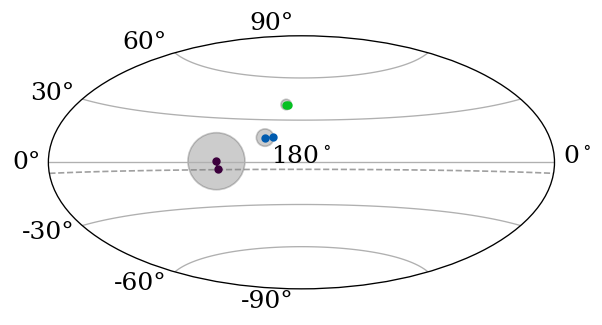

mu_inj: 5.0
plot:  1


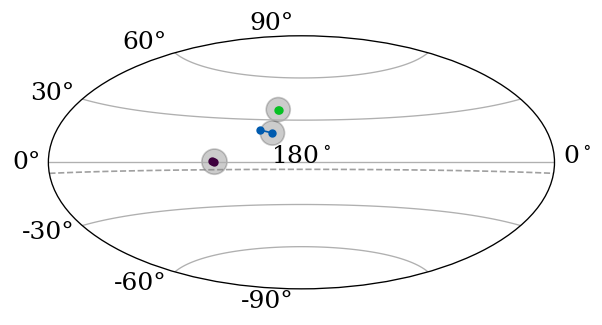

mu_inj: 7.0
plot:  2


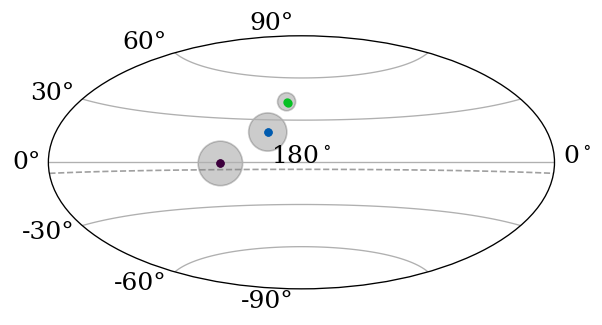

mu_inj: 1.0
plot:  3


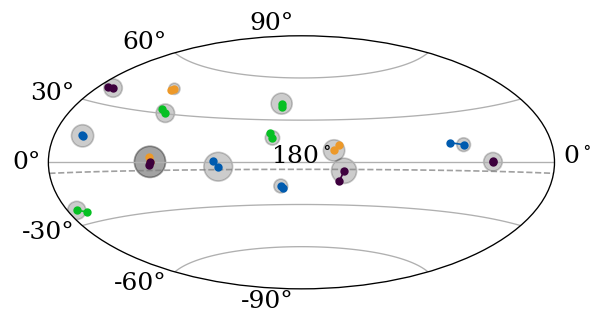

mu_inj: 3.0
plot:  4


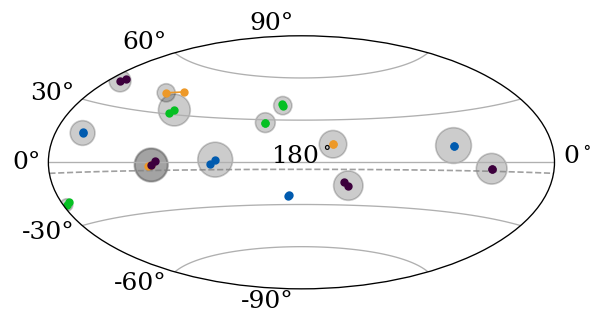

mu_inj: 5.0
plot:  5


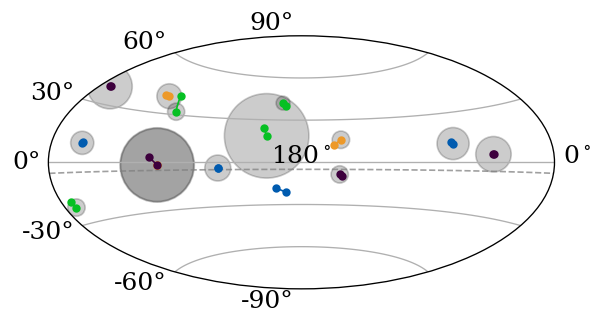

mu_inj: 1.0
plot:  6


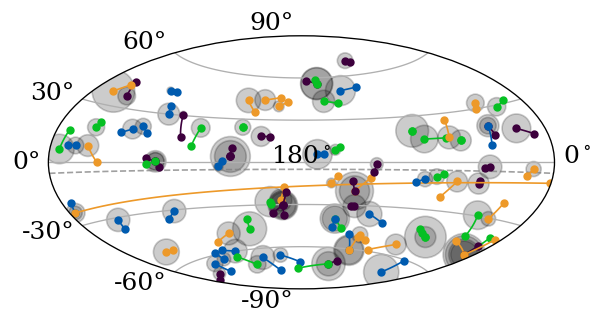

mu_inj: 2.0
plot:  7


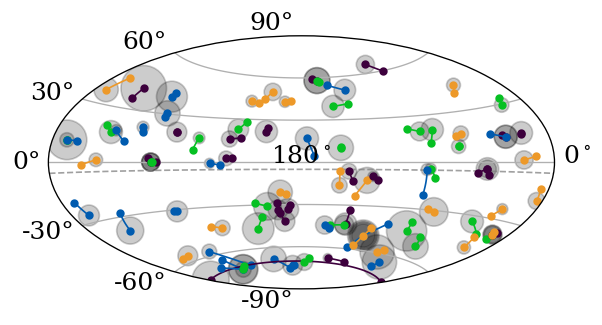

mu_inj: 4.0
plot:  8


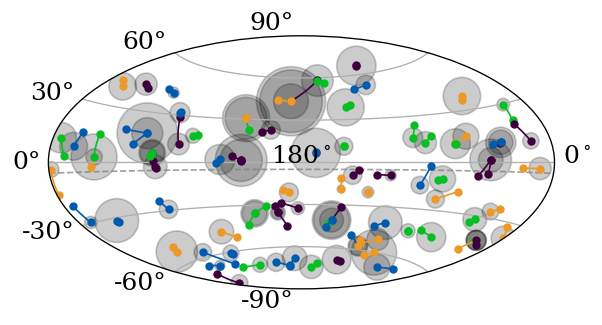

mu_inj: 2.0
plot:  9


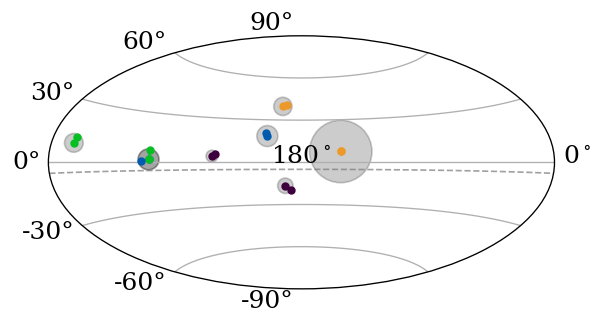

mu_inj: 4.0
plot:  10


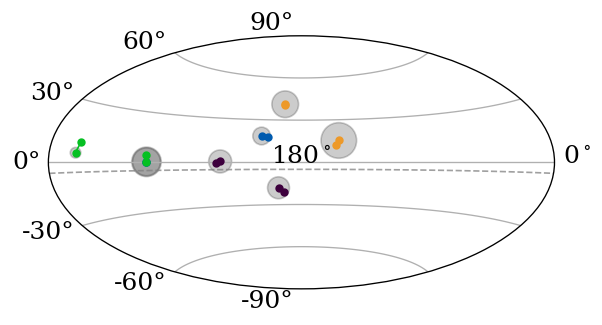

mu_inj: 6.0
plot:  11


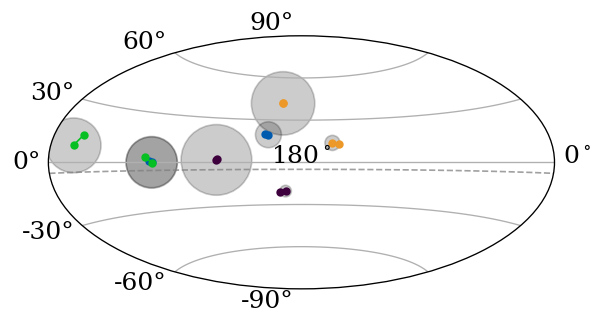

mu_inj: 1.0
plot:  12


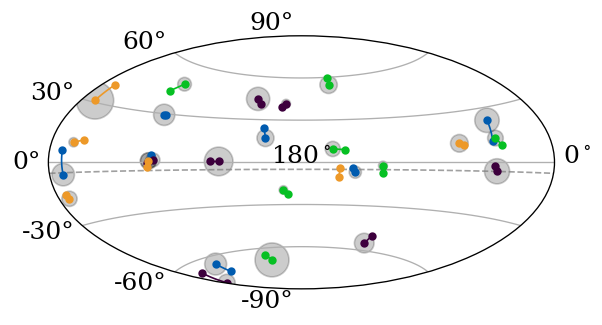

mu_inj: 3.0
plot:  13


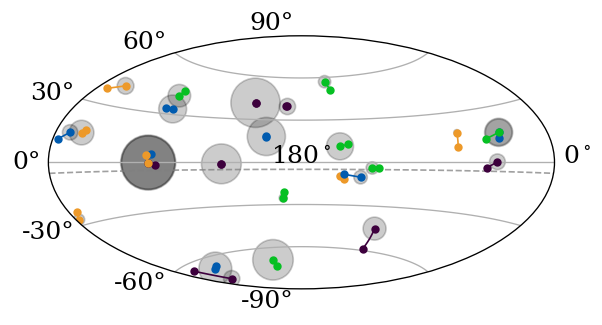

mu_inj: 4.0
plot:  14


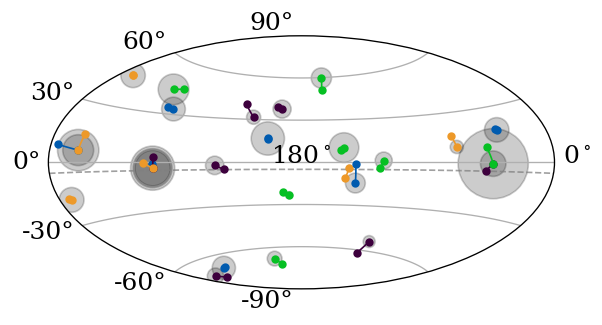

mu_inj: 10.0
plot:  15


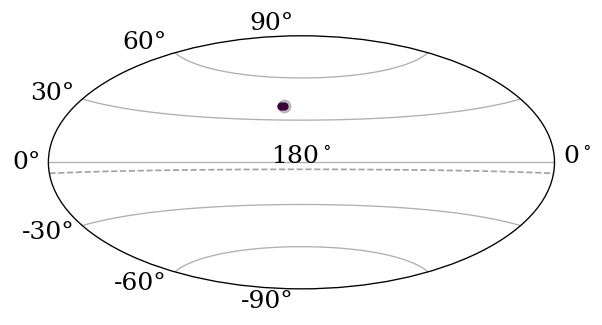

mu_inj: 3.0
plot:  16


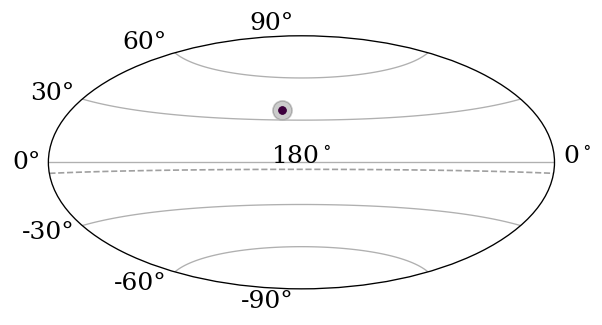

mu_inj: 5.0
plot:  17


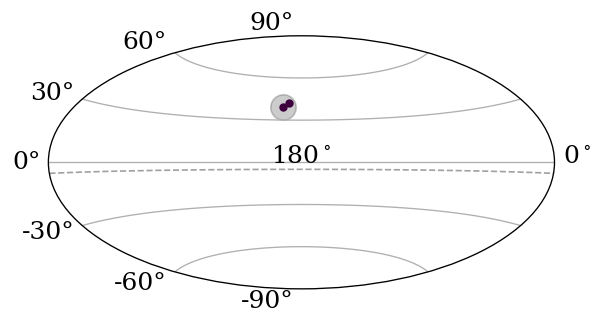

mu_inj: 14.0
plot:  18


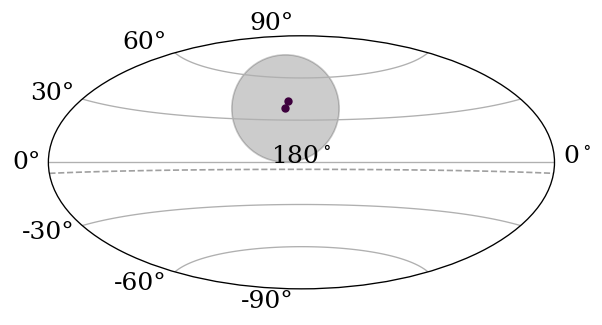

mu_inj: 15.0
plot:  19


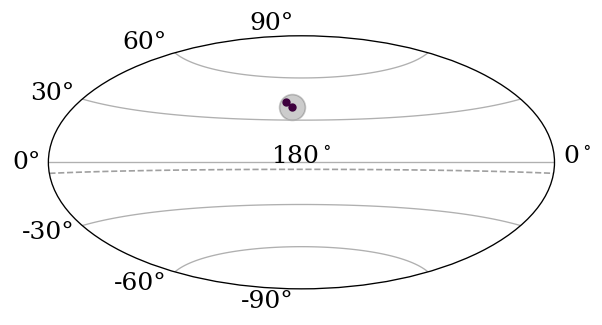

mu_inj: 1.0
plot:  20


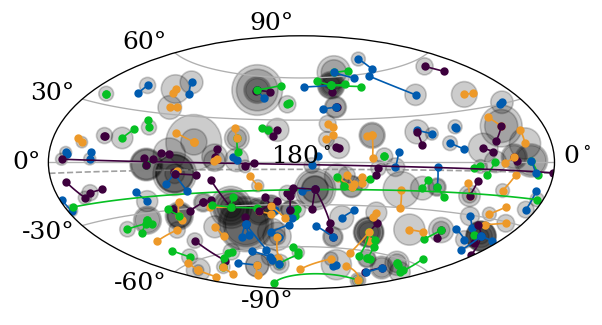

mu_inj: 2.0
plot:  21


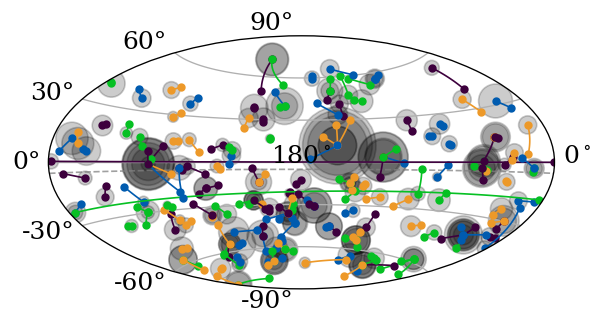

mu_inj: 4.0
plot:  22


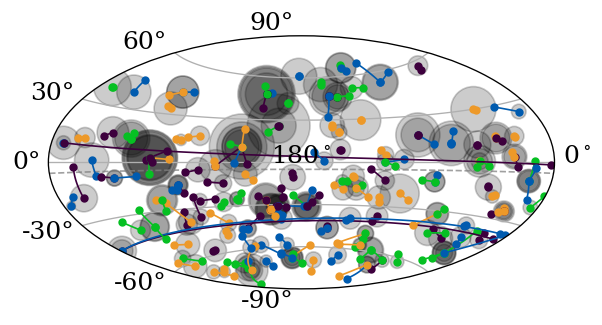

mu_inj: 8.0
plot:  23


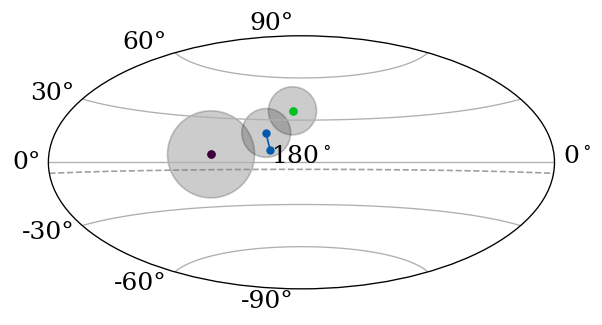

mu_inj: 9.0
plot:  24


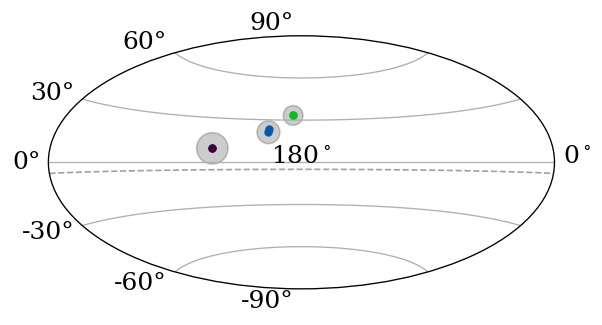

mu_inj: 3.0
plot:  25


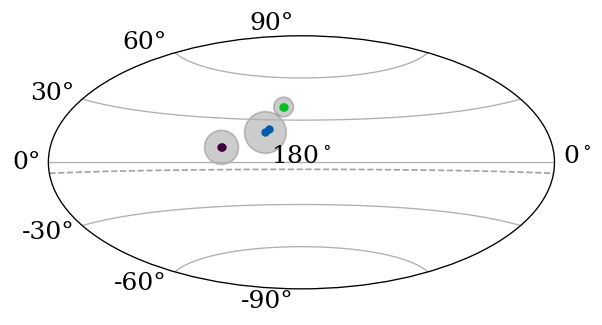

mu_inj: 5.0
plot:  26


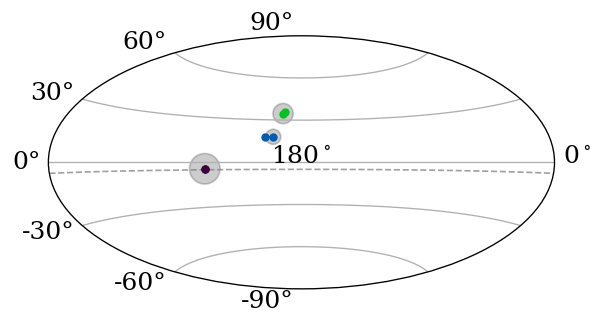

mu_inj: 7.0
plot:  27


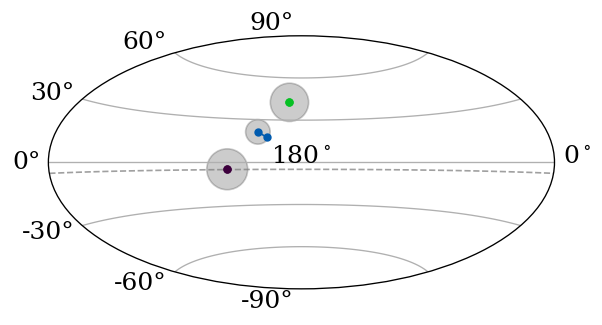

mu_inj: 2.0
plot:  28


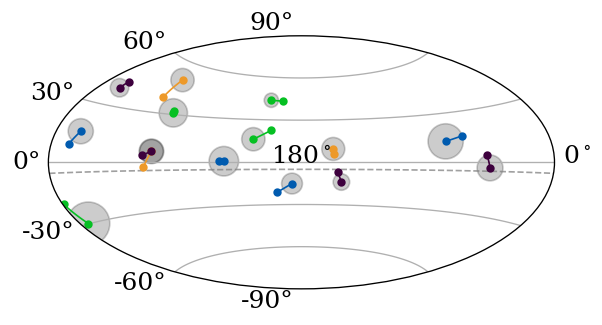

mu_inj: 4.0
plot:  29


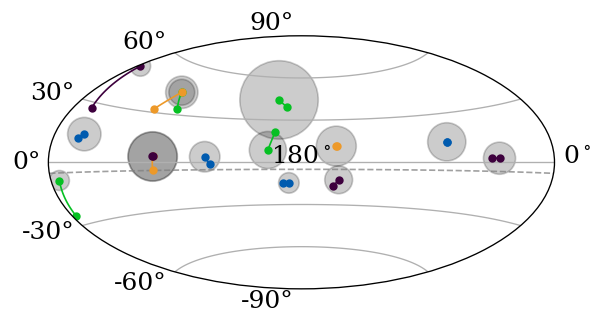

mu_inj: 6.0
plot:  30


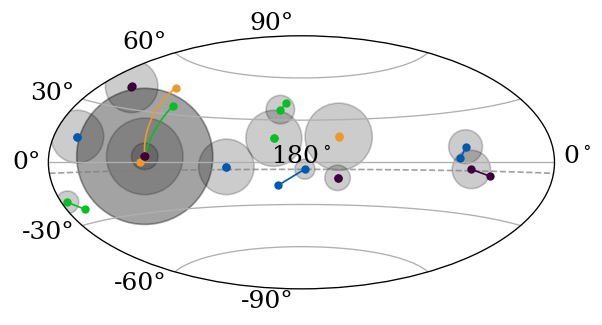

mu_inj: 1.0
plot:  31


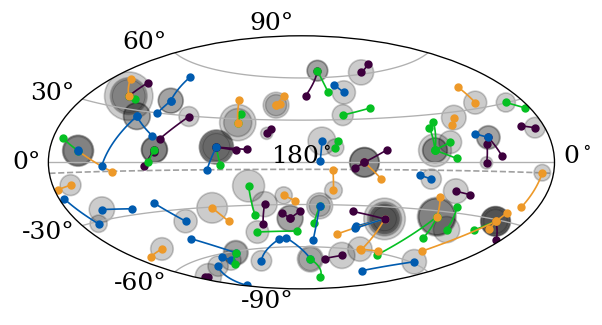

mu_inj: 2.0
plot:  32


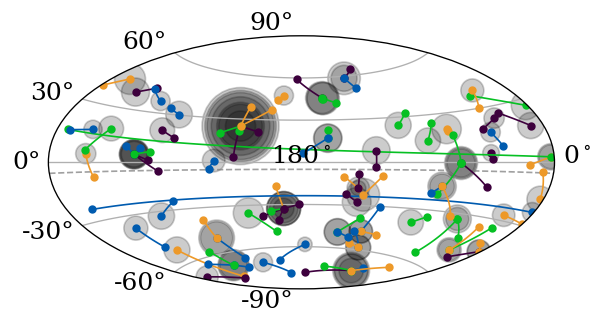

mu_inj: 3.0
plot:  33


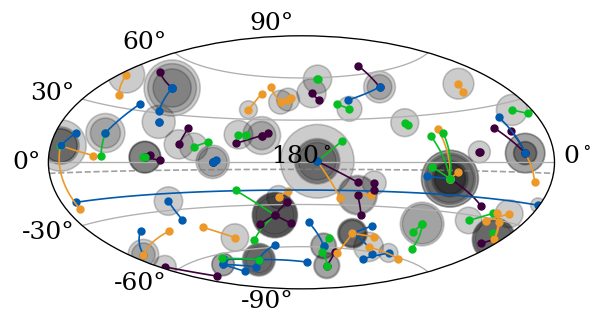

mu_inj: 4.0
plot:  34


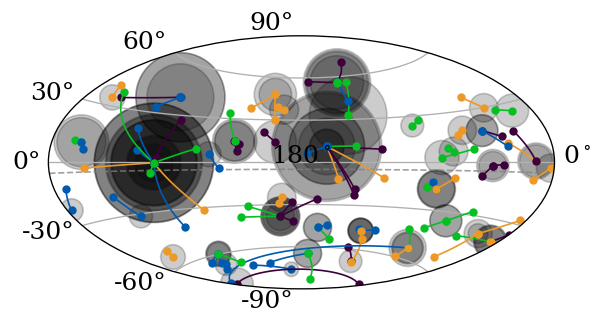

mu_inj: 5.0
plot:  35


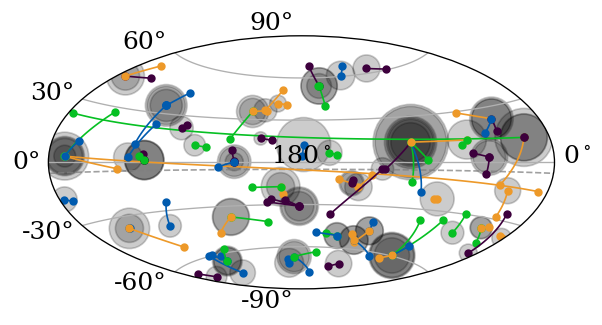

mu_inj: 2.0
plot:  36


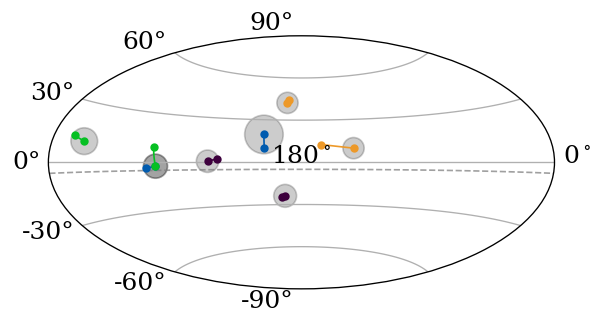

mu_inj: 4.0
plot:  37


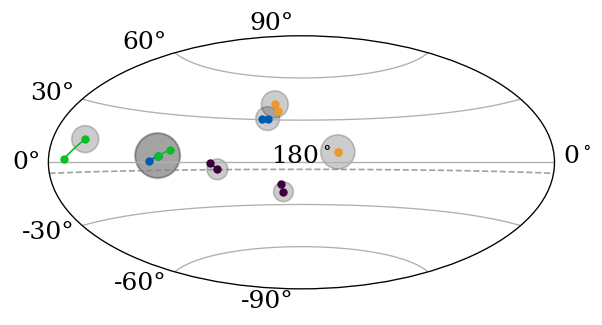

mu_inj: 6.0
plot:  38


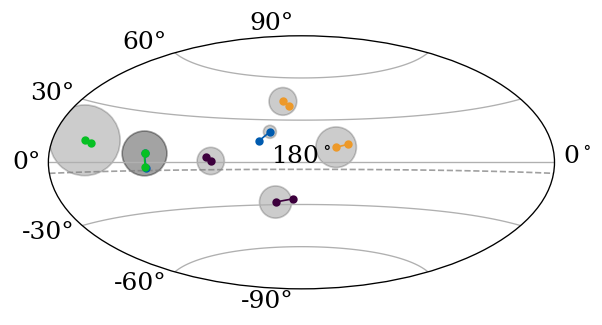

mu_inj: 1.0
plot:  39


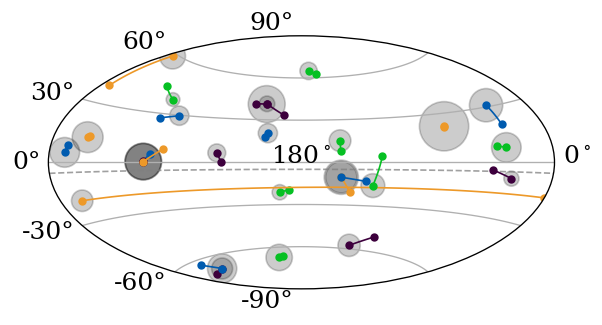

mu_inj: 2.0
plot:  40


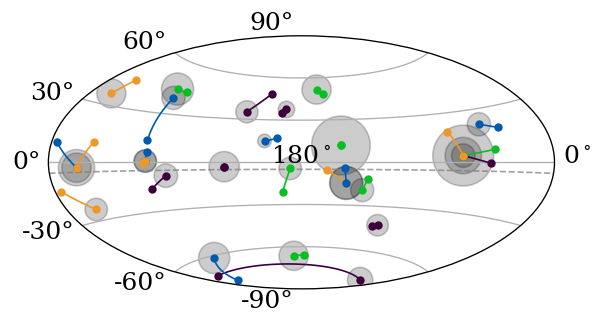

mu_inj: 3.0
plot:  41


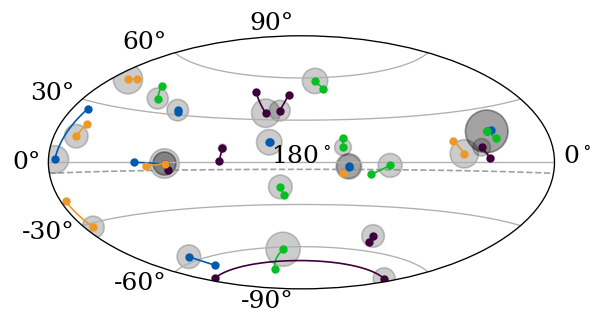

mu_inj: 5.0
plot:  42


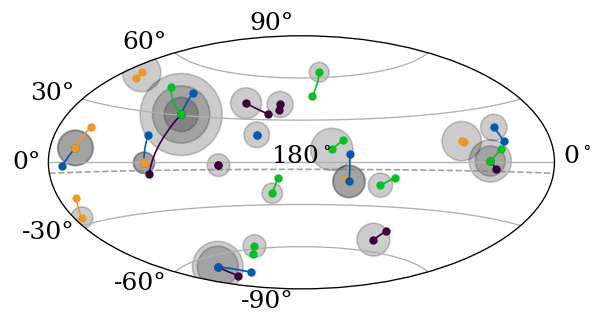

mu_inj: 10.0
plot:  43


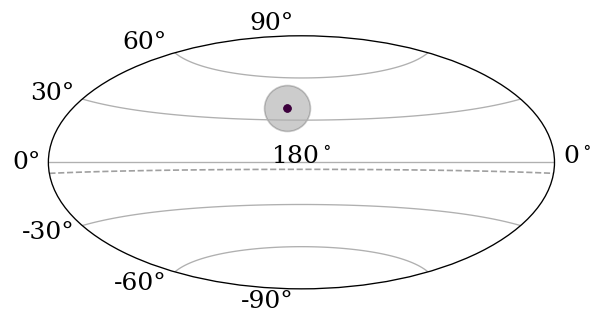

mu_inj: 3.0
plot:  44


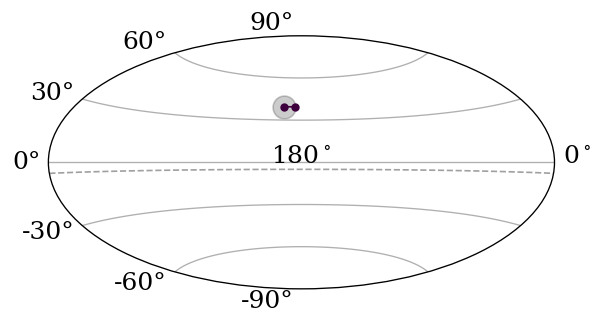

mu_inj: 5.0
plot:  45


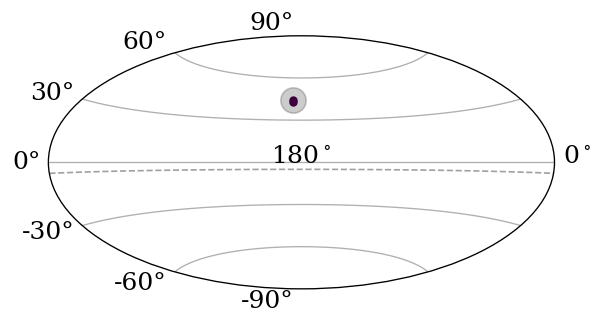

mu_inj: 14.0
plot:  46


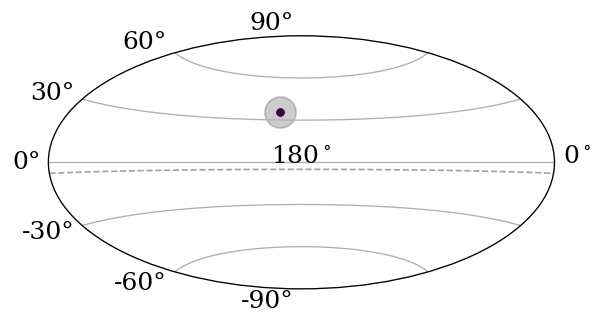

mu_inj: 15.0
plot:  47


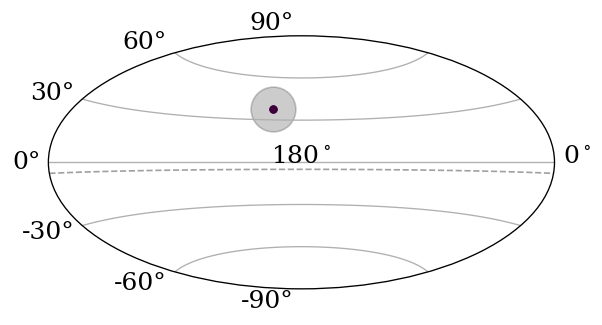

mu_inj: 1.0
plot:  48


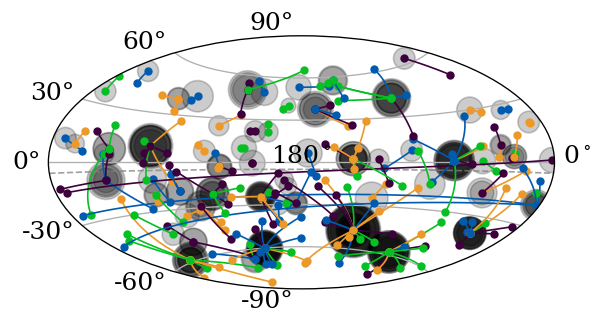

mu_inj: 2.0
plot:  49


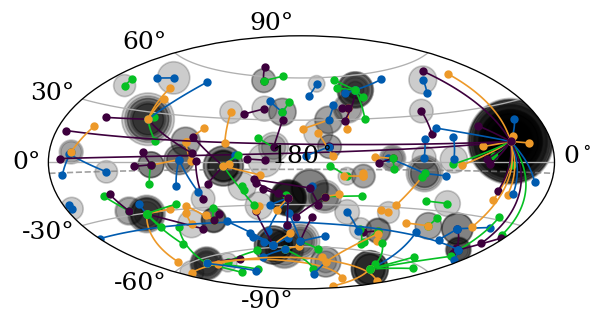

mu_inj: 4.0
plot:  50


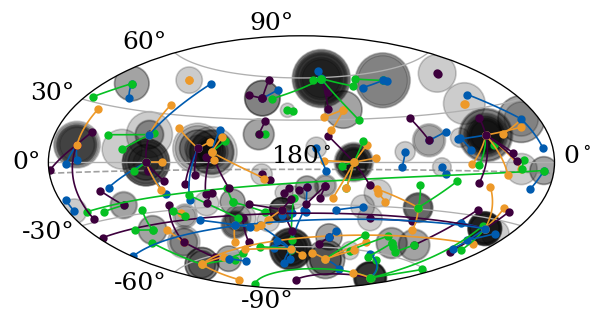

In [212]:
fcounter=0
for md in signals:   
    for ecut in signals[md]:
        c = 5
        for i,ak in enumerate(signals[md][ecut]):
            fig, ax = utils.simple_skymap(plt)
            print "mu_inj:", ak
            print "plot: ", fcounter
            sig = np.array(signals[md][ecut][ak])
            ax.plot([np.pi-sig['ra'][c].flatten(), np.pi-sig['ra_inj'][c].flatten()], 
                     [sig['dec'][c].flatten(), sig['dec_inj'][c].flatten()],
                     marker="o", ls="-", lw=1, markersize=4
                    )
            ax.scatter(np.pi-sig['ra'][c].flatten(), 
                    sig['dec'][c].flatten(),
                    marker="o", s=sig['best'][c].flatten()**2*2, color="black", alpha=0.2
                   )
            plt.savefig(os.path.join(figurepath, "HSP_eval", "HSP_dot_line_visualization_ecut{}_md{}_mu{}.png".format(ecut, md, ak)))
            fcounter+=1
            plt.show()
            """
            break
        break
    break#"""


In [214]:
import ic_utils as utils

In [220]:
t = UhecrPriorGenerator(6)
fcounter=0
j = 0
for m,md in enumerate(mdparams):   
    for j,ecut in enumerate(ecuts):
        template = t.calc_template(np.radians(md),
                        t._get_UHECR_positions(ecut,
                        data_path=crpath))#"/home/home2/institut_3b/lschumacher/phd_stuff/phd_code_git/data"))
        print("Selected {} CRs".format(t.n_uhecr))
        print("Above energies of {} EeV".format(min(t.energy)))
        print("Smeared with {} deg prior".format(md))

        tm = np.exp(template)
        tm = tm/tm.sum(axis=1)[np.newaxis].T
        tm = tm.sum(axis=0)
        vmin = 0
        vmax = max(tm)

         
        for i,ak in enumerate(signals[md][ecut]):
            fig, ax = utils.skymap(plt, tm, cmap=utils.cmap,
                               vmin=vmin, vmax=vmax, plot_cb=False,
                               rasterized=True)
            #if ak < 8: continue
            print "mu_inj:", ak
            print "plot: ", fcounter
            sig = np.array(signals[md][ecut][ak])
            ax.scatter(np.pi- sig['ra'][0].flatten(), 
                sig['dec'][0].flatten(), 
                marker="o", 
                alpha=0.15, 
                color="cyan",
                label="Fitted",
                s=sig['nsources'][0].flatten()**2)
            ax.scatter(np.pi- sig['ra_inj'][0].flatten(), 
                sig['dec_inj'][0].flatten(), 
                marker="o", 
                alpha=0.5, 
                color="magenta",
                label="injected",
                s=sig['n_inj'][0].flatten()**2)
            plt.savefig(os.path.join(figurepath, "HSP_eval", "HSP_prior_dot_visualization_ecut{}_md{}_mu{}.png".format(ecut, md, ak)))
            plt.close("all")
            #plt.show()
            """
            break
        break
    break
    #"""

#plt.savefig(join(figurepath, "full_test_template.png"))

Selected 175 CRs
Above energies of 60.0 EeV
Smeared with 3 deg prior
mu_inj: 1.0
plot:  0
mu_inj: 2.0
plot:  0
mu_inj: 4.0
plot:  0
Selected 87 CRs
Above energies of 70.0 EeV
Smeared with 3 deg prior
mu_inj: 1.0
plot:  0
mu_inj: 2.0
plot:  0
mu_inj: 4.0
plot:  0
Selected 27 CRs
Above energies of 85.3 EeV
Smeared with 3 deg prior
mu_inj: 1.0
plot:  0
mu_inj: 3.0
plot:  0
mu_inj: 4.0
plot:  0
Selected 15 CRs
Above energies of 100.1 EeV
Smeared with 3 deg prior
mu_inj: 1.0
plot:  0
mu_inj: 3.0
plot:  0
mu_inj: 5.0
plot:  0
Selected 8 CRs
Above energies of 117.9111 EeV
Smeared with 3 deg prior
mu_inj: 2.0
plot:  0
mu_inj: 4.0
plot:  0
mu_inj: 6.0
plot:  0
Selected 3 CRs
Above energies of 134.2584 EeV
Smeared with 3 deg prior
mu_inj: 3.0
plot:  0
mu_inj: 5.0
plot:  0
mu_inj: 7.0
plot:  0
Selected 1 CRs
Above energies of 180.3336 EeV
Smeared with 3 deg prior
mu_inj: 10.0
plot:  0
mu_inj: 3.0
plot:  0
mu_inj: 5.0
plot:  0
mu_inj: 14.0
plot:  0
mu_inj: 15.0
plot:  0
Selected 175 CRs
Above ener

## bckg

In [ ]:
t = UhecrPriorGenerator(6)
fcounter=0
ecut = 60
j = 0
for m,md in enumerate(mdparams):   
    #for j,ecut in enumerate(ecuts):
    template = t.calc_template(np.radians(md),
                    t._get_UHECR_positions(ecut,
                    data_path=crpath))#"/home/home2/institut_3b/lschumacher/phd_stuff/phd_code_git/data"))
    print("Selected {} CRs".format(t.n_uhecr))
    print("Above energies of {} EeV".format(min(t.energy)))
    print("Smeared with {} deg prior".format(md))

    tm = np.exp(template)
    tm = tm/tm.sum(axis=1)[np.newaxis].T
    tm = tm.sum(axis=0)
    vmin = 0
    vmax = max(tm)

    fig, ax = utils.skymap(plt, tm, cmap=utils.cmap,
                           vmin=vmin, vmax=vmax,
                           rasterized=True) 
    #"""
    ax.scatter(np.pi- bg_TS[md]['ra'][0].flatten(), 
                bg_TS[md]['dec'][0].flatten(), 
                marker="o", 
                alpha=0.15, 
                color="cyan",
                label="Fitted",
                s=bg_TS[md]['nsources'][0].flatten()**2)
    #"""
    #plt.savefig(os.path.join(figurepath, str(fcounter)+"_HSP_prior_dot_visualization_ecut{}_md{}_mu{}.png".format(ecut, md, ak)))
    fcounter+=1
    plt.show()

#plt.savefig(join(figurepath, "full_test_template.png"))

## check on (un)biased parameter estimates

In [ ]:
tw = 5
gr = 1.5 #0.5*(1. + np.sqrt(5))
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/gr)
mpl.rcParams.update(rcParams)

## With different cuts on E
## Sensitivity and disc pot


figure_counter = 43
for md in mdparams:
    print "md: ", md 
    for ecut in ecuts:
        print " * "*20 
        ## Use Percentiles, because most fits are unstable
        bins=10 
        sig_val = []
        #plotting=True
        for i,ak in enumerate(signals[md][ecut]): 
            print "mu injected: ", ak
            signals[md][ecut][ak] = np.array(signals[md][ecut][ak])
            best = signals[md][ecut][ak]['best'].flatten()
            
            plt.figure(figure_counter)
            figure_counter+=1
            sns.distplot(best, bins=bins, rug=False, kde=False, 
                        hist_kws=dict(normed=True, color=utils.colors[i%clen]), 
                        fit_kws=dict( color=utils.colors[i%clen]),
                        #label=r"$\langle n_{{inj}} \rangle $={:1.0f}".format(sig_val[-1][0])
                        ) 
            plt.legend(loc=2, ncol=2)
            plt.ylim(1e-6,1)
            plt.xlabel("TS")
            plt.ylabel("a.u.")
            plt.semilogy(nonposy="clip") 
            print figure_counter
            plt.show()

In [ ]:
tw = 5
gr = 1.5 #0.5*(1. + np.sqrt(5))
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/gr)
mpl.rcParams.update(rcParams)

## With different cuts on E
## Sensitivity and disc pot


figure_counter = 43
for md in mdparams:
    print "md: ", md 
    for ecut in ecuts:
        print " * "*20 
        ## Use Percentiles, because most fits are unstable
        bins=np.linspace(-np.pi/2., np.pi/2., 100)
        sig_val = []
        #plotting=True
        for i,ak in enumerate(signals[md][ecut]): 
            print "mu injected: ", ak
            signals[md][ecut][ak] = np.array(signals[md][ecut][ak])
            best = signals[md][ecut][ak]['dec'].flatten()
            best_inj = signals[md][ecut][ak]['dec_inj'].flatten()
            
            plt.figure(figure_counter)
            figure_counter+=1
            sns.distplot(best, bins=bins, rug=False, kde=False, 
                        hist_kws=dict(normed=True, color=utils.colors[i%clen]), 
                        fit_kws=dict( color=utils.colors[i%clen]),
                        #label=r"$\langle n_{{inj}} \rangle $={:1.0f}".format(sig_val[-1][0])
                        ) 
            sns.distplot(best_inj, bins=bins, rug=False, kde=False, 
                        hist_kws=dict(normed=True, color="gray"), 
                        fit_kws=dict(color="gray"),
                        #label=r"$\langle n_{{inj}} \rangle $={:1.0f}".format(sig_val[-1][0])
                        ) 
            plt.legend(loc=2, ncol=2)
            #plt.ylim(1e-6,100)
            plt.xlabel("dec")
            plt.ylabel("a.u.")
            plt.semilogy(nonposy="clip") 
            print figure_counter
            plt.show()

In [ ]:
tw = 5
gr = 1.5 #0.5*(1. + np.sqrt(5))
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/gr)
mpl.rcParams.update(rcParams)

## With different cuts on E
## Sensitivity and disc pot


figure_counter = 43
for md in mdparams:
    print "md: ", md 
    for ecut in ecuts:
        print "ecut: ", ecut
        print " * "*20 
        ## Use Percentiles, because most fits are unstable
        bins=20 
        sig_val = []
        #plotting=True
        for i,ak in enumerate(signals[md][ecut]): 
            print "mu injected: ", ak
            signals[md][ecut][ak] = np.array(signals[md][ecut][ak])
            best = signals[md][ecut][ak]['gamma'].flatten()
            
            plt.figure(figure_counter)
            figure_counter+=1
            sns.distplot(best, bins=bins, rug=False, kde=False, 
                        hist_kws=dict(normed=False, color=utils.colors[i%clen])
                        ) 
            plt.vlines(2.19, 0.01, 1e2)
            plt.legend(loc=2, ncol=2)
            #plt.ylim(1e-6,1e2)
            plt.xlabel("gamma")
            plt.ylabel("a.u.")
            plt.semilogy(nonposy="clip") 
            print figure_counter
            plt.show()